# Modeling Crop Yield: Landsat + Sentinel
## Python modules

In [2]:
## import warnings
import time
import math
import os
import glob
from pyhere import here
from datetime import date
import re

import numpy as np
import pandas as pd
import geopandas
import pickle

import pyarrow
import itertools
import multiprocessing
import p_tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.metrics import r2_score
from scipy.stats import spearmanr,  pearsonr

In [3]:
def split_fn(file_name):
    f            = file_name.split(sep="_")
    satellite    = f[0],
    bands        = f[1].replace("bands-", "")
    country_code = f[2],
    points       = f[3].replace("k-points", "")
    num_features = f[4].replace("-features", "")
    yrs          = f[5].replace("yr-", "")
    mns          = f[6].replace("mn-", "")
    limit_months = f[7].replace("lm-", "")
    crop_mask    = f[8].replace("cm-", "")
    weighted_avg = f[9].replace("wa-", "")
    
    return satellite, bands, country_code, points, yrs, mns, num_features, limit_months, crop_mask, weighted_avg

def merge(x, bases = (tuple, list)):
    for e in x:
        if type(e) in bases:
            for e in merge(e, bases):
                yield e
        else:
            yield e

In [4]:
files = os.listdir(here("data", "random_features", 'summary'))
files = [f for f in files if f not in ('.gitkeep', '.ipynb_checkpoints')]
# files = files[0:8]
paramlist = list(itertools.product(files, files))
paramlist = [tuple(set(paramlist[i])) for i in range(len(paramlist))]
paramlist = [x for x in paramlist if len(x) > 1] 
paramlist = list(itertools.product(paramlist, [True, False]))
for i in range(len(paramlist)):
    paramlist[i] = tuple(merge(paramlist[i]))

In [5]:
point_pattern = re.compile("20k-points")
wa_pattern = re.compile("cm-False")

paramlist = [t for t in paramlist if not (bool(point_pattern.search(t[0])) & bool(wa_pattern.search(t[0])))]
paramlist = [t for t in paramlist if not (bool(point_pattern.search(t[1])) & bool(wa_pattern.search(t[1])))]
len(paramlist)

3784

In [6]:
### best-k-fold-2-sensor-params
# f1 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
# f2 = 'sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_yr-2016-2022_mn-1-12_lm-False_cm-True_wa-False_summary.feather'
# paramlist = [(f1, f2, True)]

### best-demean-2-sensor-params
# f1 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2014-2021_mn-1-12_lm-False_cm-False_wa-True_summary.feather'
# f2 = 'sentinel-2-l2a_bands-2-3-4_ZMB_15k-points_1000-features_yr-2016-2022_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
# paramlist = [(f1, f2, True)]

### best-avg-2-2-sensor-params
# f1 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_15k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-False_wa-False_summary.feather'
# f2 = 'sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_yr-2016-2022_mn-1-12_lm-False_cm-True_wa-False_summary.feather'
# paramlist = [(f1, f2, True)]

### best-avg-3-2-sensor-params
# f1 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-points_1000-features_yr-2014-2021_mn-1-12_lm-False_cm-True_wa-True_summary.feather'
# f2 = 'sentinel-2-l2a_bands-2-3-4_ZMB_20k-points_1000-features_yr-2016-2022_mn-1-12_lm-False_cm-True_wa-False_summary.feather'
# paramlist = [(f1, f2, True)]

### demean LOGO 2-sensor-params
# f1 = 'sentinel-2-l2a_bands-2-3-4-8_ZMB_15k-points_1000-features_yr-2016-2022_mn-1-12_lm-False_cm-True_wa-True_summary.feather'
# f2 = 'landsat-8-c2-l2_bands-1-2-3-4-5-6-7_ZMB_20k-points_1000-features_yr-2013-2021_mn-4-9_lm-True_cm-True_wa-True_summary.feather'
# paramlist = [(f1, f2, True)]

# paramlist

In [27]:
# for params in paramlist[0:1]:
def model_2_sensors(params):
    #########################################     SET PARAMS    #########################################    
    f1         = params[0]
    f2         = params[1]
    hot_encode = params[2]

    satellite1, bands1, country_code, points1, yrs1, mns1,\
    num_features1, limit_months1, crop_mask1, weighted_avg1 = split_fn(f1)
    
    satellite2, bands2, country_code, points2, yrs2, mns2,\
    num_features2, limit_months2, crop_mask2, weighted_avg2 = split_fn(f2)
    
    #########################################     READ DATA    #########################################
    features_1 = pd.read_feather(here('data', 'random_features', 'summary', f1))
    features_2 = pd.read_feather(here('data', 'random_features', 'summary', f2))
    
    #########################################     CLEAN DATA    #########################################  
    min_year = max(min(features_1.year), min(features_2.year))
    max_year = min(max(features_1.year), max(features_2.year))
    
    features_1 = features_1[features_1.year >= min_year]
    features_2 = features_2[features_2.year >= min_year]
    
    features_1 = features_1[features_1.year <= max_year]
    features_2 = features_2[features_2.year <= max_year]
    
    features_1.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)
    features_2.drop(['crop_perc'], axis=1, errors='ignore', inplace=True)
    
    index_cols = ['district', 'year', 'yield_mt']
    
    features_1 = features_1.set_index(index_cols).add_prefix("f1_")
    features_2 = features_2.set_index(index_cols).add_prefix("f2_")
    
    #########################################     JOIN DATA    #########################################  
    features = features_1.join(features_2).reset_index()
    
    features = features[~features.isna().any(axis = 1)]
    
    crop_yield = features.copy().loc[:, tuple(index_cols)]
    
    if hot_encode:
        index_cols.remove('district')
        features = pd.get_dummies(features, columns = ["district"], drop_first = False)
    else:
        pass

    #########################################     SPLIT DATA    #########################################
    x_all = features.drop(index_cols, axis=1)
    x_all = StandardScaler().fit_transform(x_all)
    y_all = np.log10(features.yield_mt.to_numpy() + 1)
    g_all = features.year.ravel()
    
    x_train, x_test,\
    y_train, y_test,\
    g_train, g_test = train_test_split(x_all, y_all, g_all, test_size = 0.2, random_state = 0)

    #########################################     K-FOLD CV    ###########################################
    # ridge_kfold_cv = RidgeCV(cv = 5, alphas = np.logspace(-8, 8, base = 10, num = 17))
    # ridge_kfold_cv.fit(x_train, y_train)
    kfold = KFold()
    ridge = Ridge()
    parameters = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
    ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
    ridge_kfold_reg = GridSearchCV(ridge, parameters, scoring = 'r2', cv = kfold)
    ridge_kfold_reg.fit(x_train, y_train)
    best_kfold_model = ridge_kfold_reg.best_estimator_
    ### CV PREDICT - PREDICTING WITH BEST HYPERPARAMETER
    kfold_val_predictions = cross_val_predict(best_kfold_model, X = x_train, y = y_train, cv = kfold)   
    ### TRAIN BEST MODEL AND PREDICT
    best_kfold_model.fit(x_train, y_train)
    y_pred_train  = np.maximum(best_kfold_model.predict(x_train), 0)
    y_pred_test   = np.maximum(best_kfold_model.predict(x_test), 0)

    #########################################     LOGO CV    ###########################################
    logo = LeaveOneGroupOut()
    ridge = Ridge()
    parameters = {'alpha': np.logspace(-8, 8, base = 10, num = 17)}
    ### GRID SEARCH - FINDING BEST REGULARIZATION PARAMETER
    ridge_logo_reg = GridSearchCV(ridge, parameters, scoring = 'r2', cv = logo)
    ridge_logo_reg.fit(x_all, y_all, groups = g_all)
    best_logo_model = ridge_logo_reg.best_estimator_
    ### CV PREDICT - PREDICTING WITH BEST HYPERPARAMETER
    logo_val_predictions = cross_val_predict(best_logo_model, X = x_all, y = y_all, groups = g_all,  cv = logo)   
    
    #########################################     DE-MEAN R2    #########################################    
    crop_yield["log_yield"] = np.log10(crop_yield.yield_mt.to_numpy() + 1)
    crop_yield["district_yield_mean"] = crop_yield.groupby('district')['log_yield'].transform('mean')
    crop_yield["demean_yield"] = crop_yield["log_yield"] - crop_yield["district_yield_mean"]
    
    crop_yield["k-fold_prediction"] = np.maximum(best_kfold_model.predict(x_all), 0)
    crop_yield["k-fold_district_prediction_mean"] = crop_yield.groupby('district')['k-fold_prediction'].transform('mean')
    crop_yield["k-fold_demean_prediction"] = crop_yield["k-fold_prediction"] - crop_yield["k-fold_district_prediction_mean"]
    
    crop_yield["logo_prediction"] = np.maximum(best_logo_model.predict(x_all), 0)
    # crop_yield["logo_prediction"] = logo_val_predictions
    crop_yield["logo_district_prediction_mean"] = crop_yield.groupby('district')['logo_prediction'].transform('mean')
    crop_yield["logo_demean_prediction"] = crop_yield["logo_prediction"] - crop_yield["logo_district_prediction_mean"]
    
    #########################################     SAVE MODELS   #########################################  
    fn_1 = f'{satellite1[0]}_{bands1}_{points1}_{limit_months1}_{crop_mask1}_{weighted_avg1}'
    fn_2 = f'{satellite2[0]}_{bands2}_{points2}_{limit_months2}_{crop_mask2}_{weighted_avg2}'
    # fn_1 = f1.replace('_summary.feather', '')
    # fn_2 = f2.replace('_summary.feather', '')
    model_fn_suffix = f'fn-1_{fn_1}_fn-2_{fn_2}'
    # model_fn_suffix = 'best-avg-3-2-sensor-params'
    k_model_fn = f'k-fold-cv_rr-model_{model_fn_suffix}_he-{hot_encode}.pkl'
    logo_model_fn = f'logo-cv_rr-model_{model_fn_suffix}_he-{hot_encode}.pkl'
    
    with open(here('models', k_model_fn),'wb') as f:
        pickle.dump(best_kfold_model, f)
        
    with open(here('models', logo_model_fn),'wb') as f:
        pickle.dump(best_logo_model, f)
        
    #########################################     SAVE RESULTS    #########################################
    d = {
        'country': country_code,
        
        'satellite_1': satellite1[0],
        'bands_1': bands1,
        'num_features_1': num_features1,
        'points_1': points1, 
        'month_range_1': mns1,
        'limit_months_1': limit_months1,
        'crop_mask_1': crop_mask1,
        'weighted_avg_1': weighted_avg1,
        
        'satellite_2': satellite2[0],
        'bands_2': bands2,
        'num_features_2': num_features2,
        'points_2': points2, 
        'month_range_2': mns2,
        'limit_months_2': limit_months2,
        'crop_mask_2': crop_mask2,
        'weighted_avg_2': weighted_avg2,

        'hot_encode': hot_encode,
        
        'total_n': len(x_all),
        'train_n': len(x_train),
        'test_n': len(x_test),
        
        'kfold_best_reg_param': list(ridge_kfold_reg.best_params_.values())[0],
        'kfold_mean_of_val_R2s': ridge_kfold_reg.best_score_,
        'kfold_val_R2': r2_score(y_train, kfold_val_predictions),
        'kfold_val_r' : pearsonr(kfold_val_predictions, y_train)[0],
        'kfold_val_r2' : pearsonr(kfold_val_predictions, y_train)[0] ** 2,
        
        'kfold_train_R2': r2_score(y_train, y_pred_train),
        'kfold_train_r': pearsonr(y_pred_train, y_train)[0],
        'kfold_train_r2': pearsonr(y_pred_train, y_train)[0] ** 2,
        
        'kfold_test_R2': r2_score(y_test, y_pred_test),
        'kfold_test_r': pearsonr(y_pred_test, y_test)[0],
        'kfold_test_r2': pearsonr(y_pred_test, y_test)[0] ** 2,
        
        'logo_best_reg_param': list(ridge_logo_reg.best_params_.values())[0],      
        'logo_mean_of_val_R2s' : ridge_logo_reg.best_score_,
        'logo_val_R2' : r2_score(y_all, logo_val_predictions),
        'logo_val_r' : pearsonr(logo_val_predictions, y_all)[0],
        'logo_val_r2' : pearsonr(logo_val_predictions, y_all)[0] ** 2,
        
        'kfold_demean_R2': r2_score(crop_yield["demean_yield"], crop_yield["k-fold_demean_prediction"]),
        'kfold_demean_r':  pearsonr(crop_yield["demean_yield"], crop_yield["k-fold_demean_prediction"])[0],
        'kfold_demean_r2': pearsonr(crop_yield["demean_yield"], crop_yield["k-fold_demean_prediction"])[0] ** 2,
        
        'logo_demean_R2': r2_score(crop_yield["demean_yield"], crop_yield["logo_demean_prediction"]),
        'logo_demean_r':  pearsonr(crop_yield["demean_yield"], crop_yield["logo_demean_prediction"])[0],
        'logo_demean_r2': pearsonr(crop_yield["demean_yield"], crop_yield["logo_demean_prediction"])[0] ** 2,
    }
    df = pd.DataFrame(data=d)
    # return df
    return crop_yield

In [28]:
%%time     
##### With progress bar
workers = os.cpu_count()
if __name__ == "__main__":
    output = []
    for result in p_tqdm.p_map(model_2_sensors, paramlist):
        output.append(result)
    results = pd.concat(output).reset_index(drop=True)
    today = date.today().strftime("%Y-%m-%d")
    file_name = f'2_sensor_results_{today}.csv'
    print(f"Saving results as: {file_name}\n\n")           
    results.to_csv(here("data","results", file_name))

  0%|          | 0/1 [00:00<?, ?it/s]

Saving results as: 2_sensor_results_2022-11-11.csv


CPU times: user 164 ms, sys: 600 ms, total: 764 ms
Wall time: 24.4 s


In [29]:
results

,district,year,yield_mt,log_yield,district_yield_mean,demean_yield,k-fold_prediction,k-fold_district_prediction_mean,k-fold_demean_prediction,logo_prediction,logo_district_prediction_mean,logo_demean_prediction
0,Chadiza,2016,1.876427,0.458853,0.503862,-0.045009,0.455952,0.469358,-0.013405,0.350585,0.473674,-0.123090
1,Chadiza,2017,2.882947,0.589161,0.503862,0.085299,0.421962,0.469358,-0.047396,0.436503,0.473674,-0.037171
2,Chadiza,2018,1.299279,0.361592,0.503862,-0.142270,0.410220,0.469358,-0.059138,0.442388,0.473674,-0.031286
3,Chadiza,2019,2.131008,0.495684,0.503862,-0.008178,0.441056,0.469358,-0.028302,0.509221,0.473674,0.035546
4,Chadiza,2020,2.626538,0.559492,0.503862,0.055630,0.537070,0.469358,0.067712,0.692717,0.473674,0.219043
...,...,...,...,...,...,...,...,...,...,...,...,...
415,Zambezi,2017,1.490456,0.396279,0.436595,-0.040316,0.417738,0.430644,-0.012906,0.511513,0.513009,-0.001496
416,Zambezi,2018,1.622273,0.418678,0.436595,-0.017917,0.428774,0.430644,-0.001870,0.486318,0.513009,-0.026692
417,Zambezi,2019,1.184923,0.339436,0.436595,-0.097159,0.388848,0.430644,-0.041796,0.483137,0.513009,-0.029873
418,Zambezi,2020,1.689628,0.429692,0.436595,-0.006903,0.435576,0.430644,0.004932,0.589586,0.513009,0.076577


In [32]:
r2_score(results.log_yield, results.logo_prediction)

0.43095044199756827

In [33]:
r2_score(results.demean_yield, results.logo_demean_prediction)

-1.1920797298998393

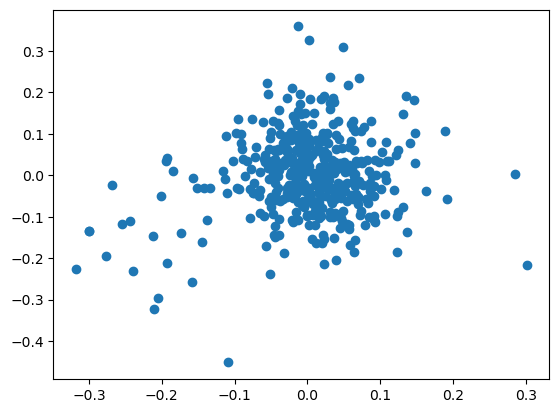

In [30]:
# import matplotlib.pyplot as plt
plt.scatter(results.demean_yield, results['logo_demean_prediction'])

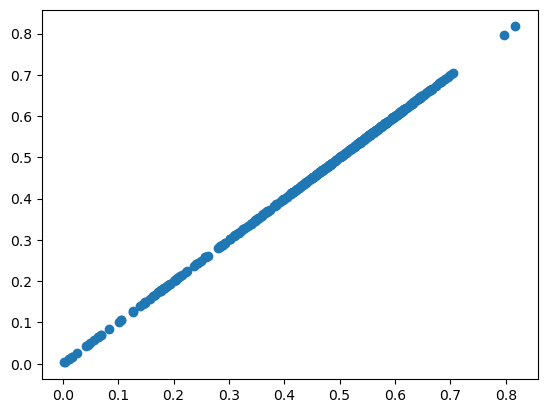

In [26]:
plt.scatter(results.log_yield, results['logo_prediction'])

In [ ]:
# %%time     
##### No progress bar
# workers = os.cpu_count()
# if __name__ == "__main__":
#     with multiprocessing.Pool(processes=workers) as pool:
#         output = []
#         for result in pool.imap_unordered(model_2_sensors, paramlist):
#             output.append(result)
#     results = pd.concat(output).reset_index(drop=True)
#     today = date.today().strftime("%Y-%m-%d")
#     file_name = f'2_sensor_results_{today}.csv'
#     print(f"Saving results as: {file_name}\n\n")           
#     results.to_csv(here("data","results", file_name))